### Testing_JHJ_for_Multiple_Sources  

Objective is to analyze the mulltiple source case and to see if the problem is diagonalizable.

Plotted are: 

1. $\mathbf{J}^H\mathbf{J}$ for up to 1000 sources   
2. $\chi^2$-error plots of LMA implementation in finding 5 sources for the diagonal and the full $\mathbf{J}^H\mathbf{J}$ matrix for different perturbation angles, for the report we tested perturbation angles: $0.01^\circ, 0.05^\circ$ and $0.5^\circ$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import ProjectPacks as pp
import ProjectFuncs as pf
%matplotlib inline

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from scipy.optimize import leastsq
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [6]:
def generate_params(Num_of_sources, pert):

    np.random.seed(41)
    lms= np.random.uniform(-1,1,2*Num_of_sources).reshape((Num_of_sources,2))
    As= np.random.uniform(1,11,Num_of_sources).reshape((Num_of_sources,1))

    x_mult= np.hstack((lms,As))
    
    np.random.seed(72)
    lms_true= lms + pert
    As_true= np.random.uniform(1,11,Num_of_sources).reshape((Num_of_sources,1))

    x_mult_true= np.hstack((lms_true,As_true))
    
    return x_mult, x_mult_true
    

In [7]:
## Choose number of timeslots
timeslots= 300
A_mod,l_mod,m_mod,ut,vt,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

ut= ut[:7,:7]
vt= vt[:7,:7]

nbl= int(len(ut)*(len(ut)-1)/2)
endt= 5
t = np.arange(0, endt, endt/timeslots)          #The points at which we will be taking our "measurements"
noise = 0.000*(np.random.normal(size=(timeslots*2*nbl))+1j*np.random.normal(size=(timeslots*2*nbl))) #A noise vector used to manufacture "real" measurements.

x, x_true= np.radians(generate_params(1000,0.5))

d = pf.modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
m = pf.modfunc(x, ut, vt)              #Our fitted function using the initial guess parameters.
r = pf.modfunc_res(x, ut, vt, d)


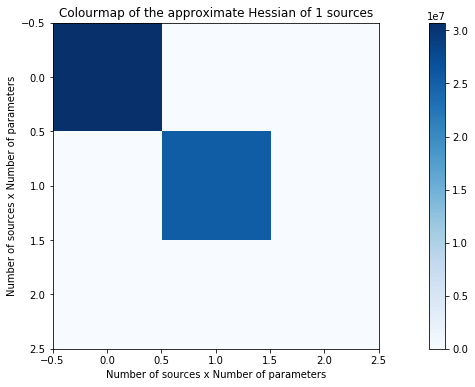

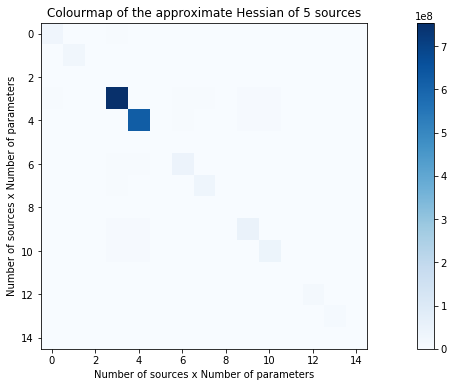

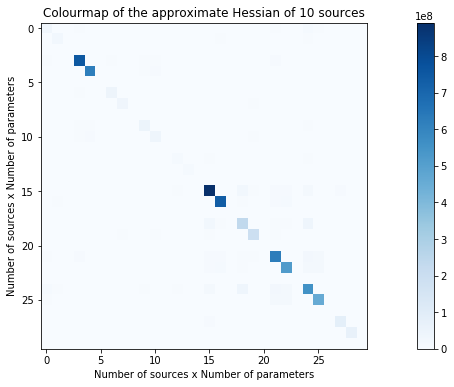

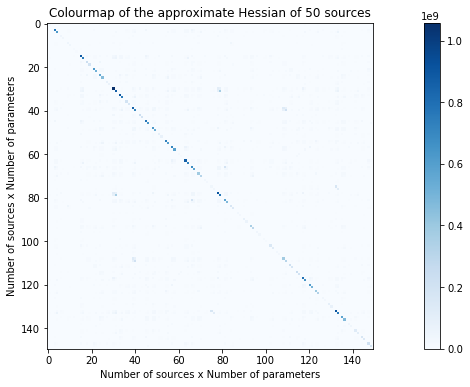

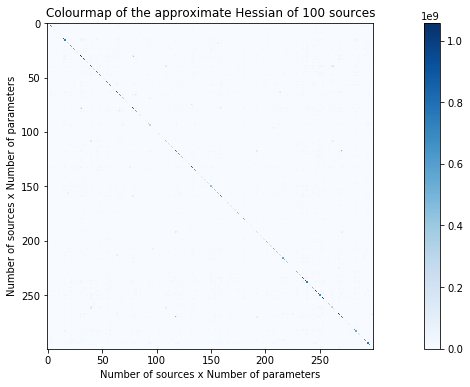

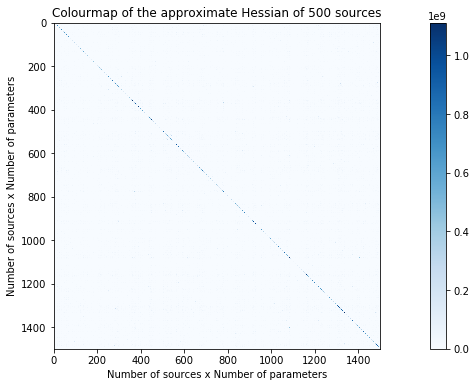

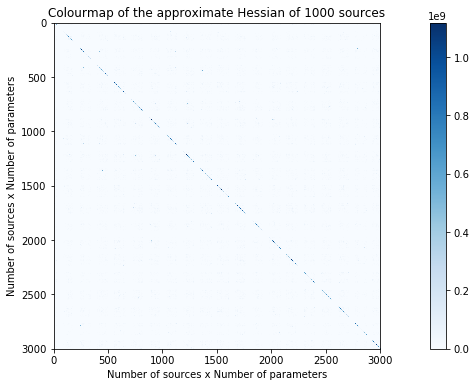

In [8]:
for i in [1,5,10,50,100,500,1000]:
    jh, jhj= pf.modfunc_jac(x[:i], ut, vt)
    
    ax= plt.imshow(np.uint(np.abs(jhj)), cmap= "Blues")
    plt.colorbar()#.set_label("JHJ matrix entry value", rotation= 270)
    plt.title("Colourmap of the approximate Hessian of {} sources".format(i))
    plt.xlabel("Number of sources x Number of parameters")
    plt.ylabel("Number of sources x Number of parameters")
    plt.show()


In [9]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func,mat="full", maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    data      Vector of measured values.
    x         Vector of parameters. (S,3)
    r_func    Function which generates the residual vector. (1,t*nb)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (S*3,t*nb) & (S*3,S*3) 
    maxit     Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0

    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        solpath= np.vstack((solpath,x))  
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        
        JH,JHJ = j_func(x,u_ant,v_ant)
        if mat == "diag":
            JHJ= np.diag(np.diag(JHJ))
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)        
        x += delta_x.real.reshape((len(x),3))
        
        #solpath= np.vstack((solpath,x))  
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real.reshape((len(x),3))
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [17]:
x_mod, x_true= np.radians(generate_params(5,0.5))
solved_x,cplot,spath = levenberg_marquardt(d,ut,vt,x_mod,pf.modfunc_res,pf.modfunc_jac,mat= "full")

Shape of residual vec:  (12600,)


In [18]:
x_modd, x_trued= np.radians(generate_params(5,0.5))
solved_xd,cplotd,spathd = levenberg_marquardt(d,ut,vt,x_modd,pf.modfunc_res,pf.modfunc_jac,mat= "diag")

Shape of residual vec:  (12600,)


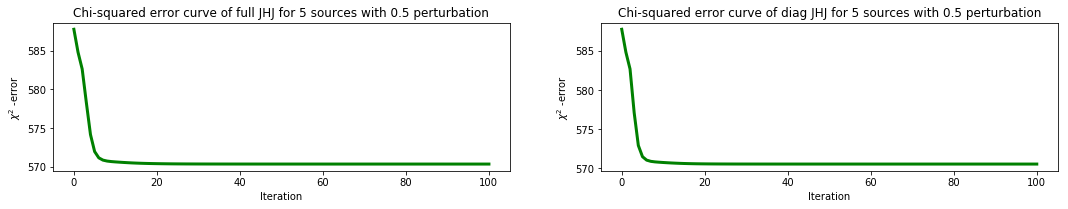

In [19]:
plt.subplot(221)
plt.plot(cplot,'g',linewidth= 3.0)
plt.xlabel("Iteration")
plt.ylabel(r'$\chi^2$'+" -error")
plt.title("Chi-squared error curve of full JHJ for 5 sources with 0.5 perturbation")
#plt.ylim([-0.5,5.5])

plt.subplot(222)
plt.plot(cplotd,'g',linewidth= 3.0)
plt.xlabel("Iteration")
plt.ylabel(r'$\chi^2$'+" -error")
plt.title("Chi-squared error curve of diag JHJ for 5 sources with 0.5 perturbation")
#plt.ylim([-0.5,5.5])

plt.show()

In [17]:
print("solved parameters for full JHJ:\n {} \n solved parameters for diag JHJ:\n {}".format(solved_x,solved_xd))
print("true x_values:\n {}".format(x_true))

solved parameters for full JHJ:
 [[-0.00929212 -0.01754807 -0.01026756]
 [ 0.00757162 -0.01143341  0.05808365]
 [-0.0137313   0.00649304  0.10286327]
 [-0.01030829  0.00711095 -0.01099218]
 [ 0.01420369 -0.00315171  0.00285911]] 
 solved parameters for diag JHJ:
 [[-0.00698724 -0.01467308 -0.01147261]
 [ 0.00759652 -0.0114619   0.0611401 ]
 [-0.02291357  0.00874256  0.00819422]
 [-0.0190759   0.00761311 -0.01309757]
 [ 0.01415663 -0.00255984  0.00465136]]
true x_values:
 [[ -2.39588788e-04   1.12307955e-04   1.62101306e-03]
 [  2.13004446e-05  -7.96957903e-05   3.18835719e-03]
 [ -5.32382035e-05   5.35197430e-05   1.57261750e-03]
 [  1.31639680e-04  -1.99016284e-04   1.05845319e-03]
 [ -2.63955689e-04   4.13592886e-07   1.53570386e-03]]
